In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.stats

# Acceptance-rejection sampling

- generate $10^6$ points uniformly within $-1, 1$ square
- compute fraction $r$ of points within a unit circle
- repeat for different dimension numbers $d: 2, 3, 4, ..., 15$
- plot $r$ as a function of $d$
- assign an uncertainty to $r$ estimation
- compare with theoretical expectation for $r$
  - $n$-ball volume: $V_n(R) = \frac{\pi^{n / 2}}{\Gamma(n/2 + 1)} R^n$
  - theoretical limit value $r = \frac{V_n(1)}{2^n}$


In [3]:
def log_factorial(n: int) -> int:
    return sum(np.log(i) for i in range(1, n + 1))


def r_theoredical(d: int) -> int:
    return np.exp(
        d / 2 * np.log(np.pi) - scipy.special.loggamma(d / 2 + 1) - d * np.log(2)
    )

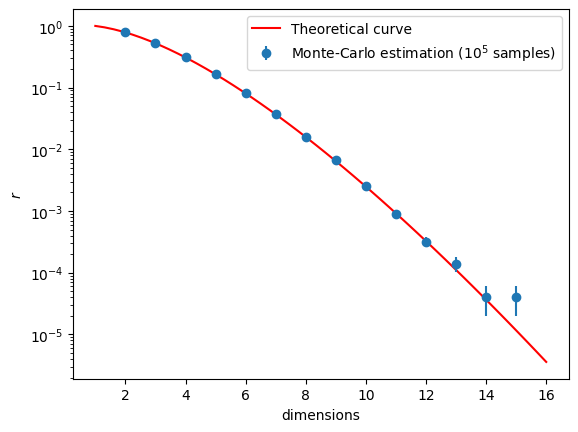

In [4]:
sample_size = int(1e5)

fig, ax = plt.subplots()

d_max = 15
d_sample = list(range(2, d_max + 1))
r_estimations = []
r_errors = []
for d in d_sample:
    points = np.random.uniform(low=-1, high=1, size=(sample_size, d))
    success_count = np.count_nonzero((points**2).sum(axis=1) < 1)
    r_est = success_count / sample_size
    r_estimations.append(r_est)
    r_errors.append(np.sqrt(sample_size * r_est * (1 - r_est)) / sample_size)

d_range = np.linspace(1, d_max + 1)
ax.plot(
    d_range,
    [r_theoredical(d) for d in d_range],
    color="r",
    label="Theoretical curve",
)

ax.errorbar(
    d_sample,
    r_estimations,
    r_errors,
    fmt="o",
    label=f"Monte-Carlo estimation ($10^{{{int(np.log10(sample_size))}}}$ samples)",
)

ax.set_yscale("log")
ax.set_xlabel("dimensions")
ax.set_ylabel("$r$")
ax.legend()

plt.show()

# Random number correlation

- generate $1 + 10^5$ numbers $x_i$ distributed $\sim \mathcal{N}(3, 2)$
- plot the distribution of $x_i$ and of $x_i - x_{i - 1}$
- do the same but with MCMC algorithm
  - use $\mathcal{N}(x_0, 0.3)$ as proposal distribution
- can we explain standard deviation of the distribution of $x_i - x_{i-1}$ for two cases?


In [35]:
import itertools
from typing import Callable


def sample_mcmc(
    pdf: Callable[[float], float],
    initial: float,
    size: int,
    step_scale: float = 0.3,
    burn_in_steps: int = 0,
    thinning: int = 1,
) -> list[float]:
    sample: list[float] = []
    current = initial
    for step in itertools.count():
        next_ = np.random.normal(loc=current, scale=step_scale)
        if pdf(next_) / pdf(current) > np.random.uniform():
            current = next_
            if step > burn_in_steps and (step - burn_in_steps) % thinning == 0:
                sample.append(current)
            if len(sample) >= size:
                return sample

In [50]:
def plot_sampling_methods_comparison(
    target_rv: scipy.stats.rv_continuous,
    sample_size: int,
    bins: int = 100,
    mcmc_step_scale: float = 0.3,
):
    fully_random_sample = target_rv.rvs(size=sample_size)
    common_sample_bin_edges = np.linspace(
        fully_random_sample.min(), fully_random_sample.max(), num=bins + 1
    )
    mcmc_naive_sample = np.array(
        sample_mcmc(
            pdf=target_rv.pdf,
            initial=target_rv.mean(),
            size=sample_size,
            step_scale=mcmc_step_scale,
        )
    )
    mcmc_burn_in_sample = np.array(
        sample_mcmc(
            pdf=target_rv.pdf,
            initial=target_rv.mean(),
            size=sample_size,
            burn_in_steps=1000,
            step_scale=mcmc_step_scale,
        )
    )
    mcmc_burn_in_thinned_sample = np.array(
        sample_mcmc(
            pdf=target_rv.pdf,
            initial=target_rv.mean(),
            size=sample_size,
            step_scale=mcmc_step_scale,
            burn_in_steps=1000,
            thinning=50,
        )
    )

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

    for label, color, sample in [
        ("Fully random", "b", fully_random_sample),
        ("MCMC naive", "r", mcmc_naive_sample),
        ("MCMC w/ burn-in", "g", mcmc_burn_in_sample),
        ("MCMC w/ burn-in & thinning", "m", mcmc_burn_in_thinned_sample),
    ]:
        kwargs = dict(color=color, density=True, label=label)
        # kwargs.update({"alpha": 0.2})
        kwargs.update({"histtype": "step", "linewidth": 1.5})
        ax1.hist(sample, bins=common_sample_bin_edges, **kwargs)
        ax2.hist(sample[1:] - sample[:-1], bins=bins, **kwargs)

    xmin, xmax = ax1.get_xlim()
    xrange = np.linspace(xmin, xmax, 500)
    ax1.plot(xrange, target_rv.pdf(xrange), "k", linewidth=1, label="True PDF")

    ax1.set_xlabel("$x$")
    ax2.set_xlabel("$x_i - x_{i-1}$")
    ax1.set_yticks([])
    ax2.set_yticks([])
    ax1.legend()
    ax2.legend()

    fig.suptitle(f"n = {sample_size}")

    plt.tight_layout()
    plt.show()

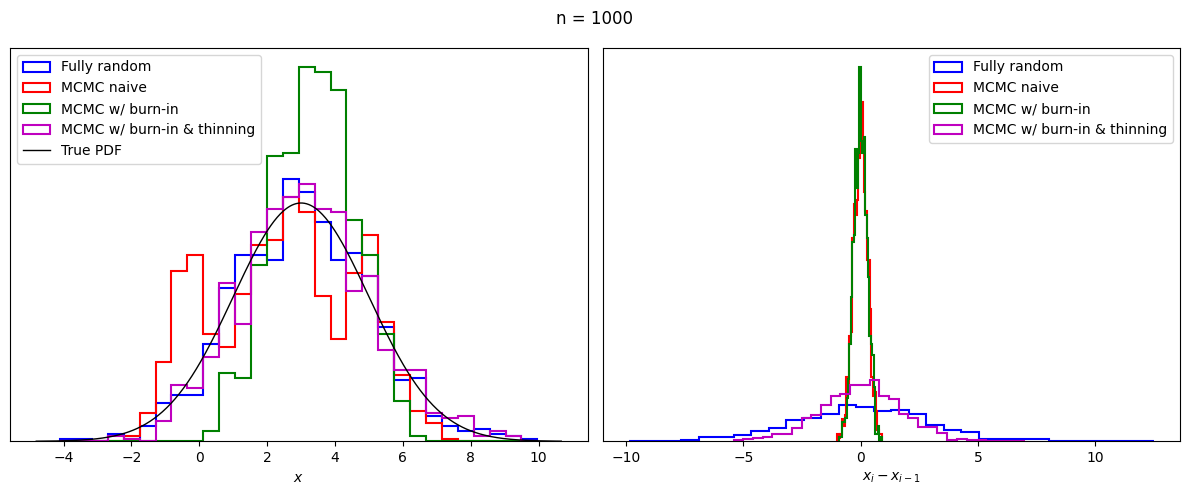

In [51]:
plot_sampling_methods_comparison(
    target_rv=scipy.stats.norm(loc=3, scale=2),
    sample_size=int(1e3),
    bins=30,
)

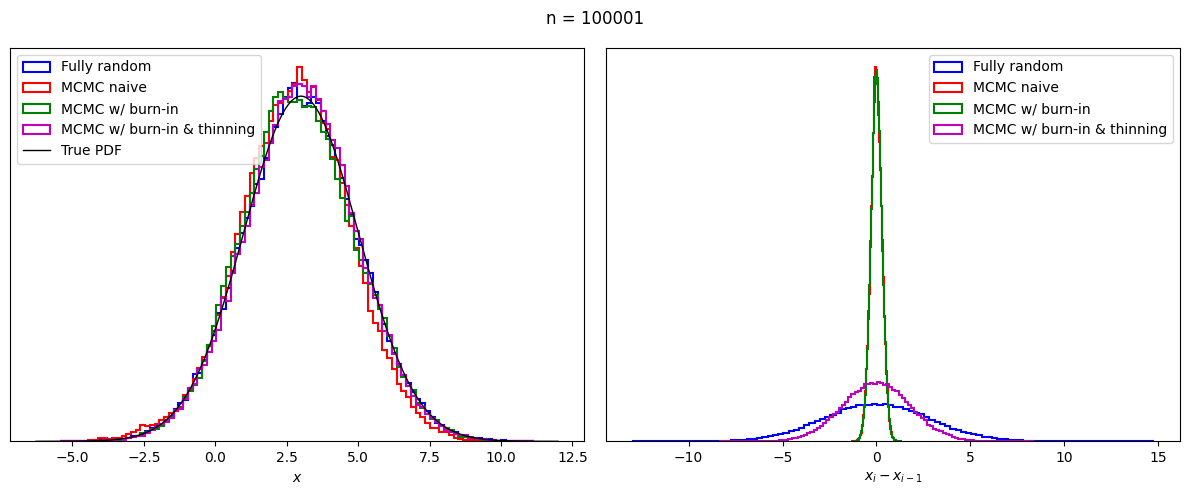

In [57]:
plot_sampling_methods_comparison(
    target_rv=scipy.stats.norm(loc=3, scale=2),
    sample_size=int(1e5) + 1,
)

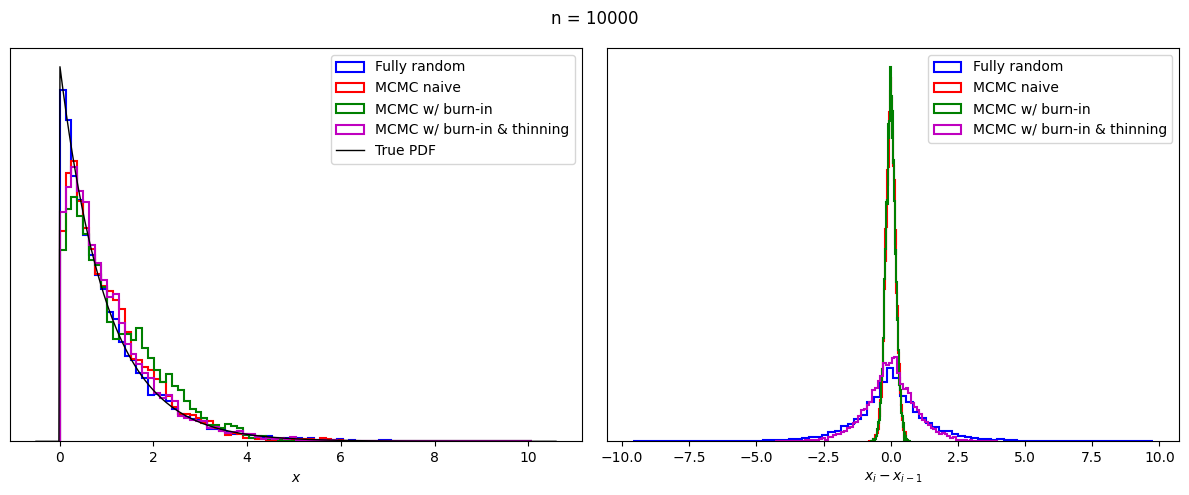

In [53]:
plot_sampling_methods_comparison(
    target_rv=scipy.stats.expon(),
    sample_size=int(1e4),
    mcmc_step_scale=0.2,
    bins=80,
)

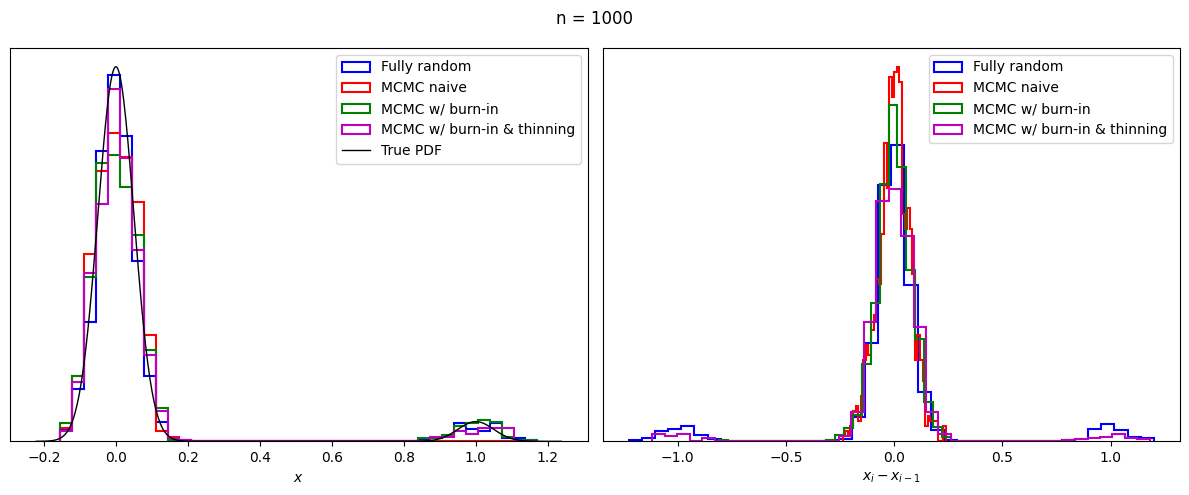

In [56]:
class custom_gaussian_mixture(scipy.stats.rv_continuous):
    AUX_PEAK_PROB = 0.05
    MU_MAIN = 0
    SIGMA_MAIN = 0.05
    MU_AUX = 1
    SIGMA_AUX = 0.05

    def _pdf(self, x):
        return (1 - self.AUX_PEAK_PROB) * (
            np.exp(-((x - self.MU_MAIN) ** 2) / (2 * self.SIGMA_MAIN**2))
            / (np.sqrt(2.0 * np.pi) * self.SIGMA_MAIN)
        ) + self.AUX_PEAK_PROB * (
            np.exp(-((x - self.MU_AUX) ** 2) / (2 * self.SIGMA_AUX**2))
            / (np.sqrt(2.0 * np.pi) * self.SIGMA_AUX)
        )

    def rvs(self, size):
        main = scipy.stats.norm.rvs(loc=self.MU_MAIN, scale=self.SIGMA_MAIN, size=size)
        aux = scipy.stats.norm.rvs(loc=self.MU_AUX, scale=self.SIGMA_AUX, size=size)
        aux_mask = scipy.stats.uniform.rvs(size=size) < self.AUX_PEAK_PROB
        main[aux_mask] = aux[aux_mask]
        return main

    def mean(self):
        return (
            self.AUX_PEAK_PROB * self.MU_AUX + (1 - self.AUX_PEAK_PROB) * self.MU_MAIN
        )

    def std(self):
        return np.sqrt(
            self.AUX_PEAK_PROB * (self.MU_AUX**2 + self.SIGMA_AUX**2)
            + (1 - self.AUX_PEAK_PROB) * (self.MU_MAIN**2 + self.SIGMA_MAIN**2)
            - self.mean() ** 2
        )


plot_sampling_methods_comparison(
    target_rv=custom_gaussian_mixture(),
    sample_size=int(1e3),
    mcmc_step_scale=0.3,
    bins=40,
)